In [ ]:
from google.colab import drive
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Positive Examples (Keep only entries where the Rating column is not null)

normalized_jester_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/jester/normalized_jester.csv')
normalized_reddit_jokes_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_reddit_jokes.csv')
normalized_stupidstuff_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_stupidstuff.csv')

normalized_jester_df = normalized_jester_df[normalized_jester_df['Rating'].notna()]
normalized_reddit_jokes_df = normalized_reddit_jokes_df[normalized_reddit_jokes_df['Rating'].notna()]
normalized_stupidstuff_df = normalized_stupidstuff_df[normalized_stupidstuff_df['Rating'].notna()]

# Negative Examples (All of them, put 0 in the Rating column)

news_category_dataset_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Negative-Examples/News_Category_Dataset_v3/News_Category_Dataset_v3.csv')
news_category_dataset_df['Rating'] = news_category_dataset_df['Rating'].fillna(0.0)

combined_df = pd.concat([normalized_jester_df, normalized_reddit_jokes_df, normalized_stupidstuff_df, news_category_dataset_df], ignore_index=True)

In [ ]:
combined_df.head()

,ID,Title,Category,Body,Rating
0,5,NaN,NaN,Q.\tWhat's O. J. Simpson's Internet address? \...,0.153659
1,7,NaN,NaN,How many feminists does it take to screw in a ...,0.145475
2,8,NaN,NaN,Q. Did you hear about the dyslexic devil worsh...,0.321407
3,13,NaN,NaN,They asked the Japanese visitor if they have e...,0.334060
4,15,NaN,NaN,Q: What did the blind person say when given s...,0.212328


In [ ]:
def preprocessed_sample(sample):
  sample = str(sample)
  sample = re.sub(r'[^a-zA-Z0-9\s]', '', sample) # Only letters (lowercase and uppercase) + digits
  sample = sample.lower() # Everything lowercase
  sample = re.sub(r'\d+', 'NUMBER', sample) # Replace all numerical values with a common label.
  return sample

combined_df['Body'] = combined_df['Body'].apply(preprocessed_sample)

In [ ]:
combined_df.head()

,ID,Title,Category,Body,Rating
0,5,NaN,NaN,q\twhats o j simpsons internet address \r\na\t...,0.153659
1,7,NaN,NaN,how many feminists does it take to screw in a ...,0.145475
2,8,NaN,NaN,q did you hear about the dyslexic devil worshi...,0.321407
3,13,NaN,NaN,they asked the japanese visitor if they have e...,0.334060
4,15,NaN,NaN,q what did the blind person say when given so...,0.212328


In [ ]:
TEST_PERCENTAGE_FROM_ALL = 0.2
VAL_PERCENTAGE_FROM_TRAIN = 0.2

# Ensure there are jokes and non-jokes in each dataset.

X_train_zero = combined_df[combined_df['Rating'] == 0.0]['Body']
y_train_zero = combined_df[combined_df['Rating'] == 0.0]['Rating']

X_train_notzero = combined_df[combined_df['Rating'] != 0.0]['Body']
y_train_notzero = combined_df[combined_df['Rating'] != 0.0]['Rating']

X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(X_train_zero, y_train_zero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_zero, X_val_zero, y_train_zero, y_val_zero = train_test_split(X_train_zero, y_train_zero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

X_train_notzero, X_test_notzero, y_train_notzero, y_test_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_notzero, X_val_notzero, y_train_notzero, y_val_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

# Form Datasets

X_train = pd.concat([X_train_zero, X_train_notzero])
y_train = pd.concat([y_train_zero, y_train_notzero])

X_val = pd.concat([X_val_zero, X_val_notzero])
y_val = pd.concat([y_val_zero, y_val_notzero])

X_test = pd.concat([X_test_zero, X_test_notzero])
y_test = pd.concat([y_test_zero, y_test_notzero])

print('Train zero:', X_train_zero.shape[0], 'Train not zero:', X_train_notzero.shape[0])
print('Val zero:', X_val_zero.shape[0], 'Val not zero:', X_val_notzero.shape[0])
print('Test zero:', X_test_zero.shape[0], 'Test not zero:', X_test_notzero.shape[0])

Train zero: 173513 Train not zero: 87601
Val zero: 43379 Val not zero: 21901
Test zero: 54223 Test not zero: 27376


Vectorizer Method:

In [ ]:
# vectorizer = CountVectorizer(max_features=1024)
vectorizer = TfidfVectorizer(max_features=4096)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
class FeaturesDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.toarray(), dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length


class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # self.layers.append(nn.Sigmoid())

  def forward(self, X):
    return self.layers(X)

In [ ]:
BATCH_SIZE = 64

train_dataset = FeaturesDataset(X_train_vec, y_train)
val_dataset = FeaturesDataset(X_val_vec, y_val)
test_dataset = FeaturesDataset(X_test_vec, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNetwork(input_size=X_train_vec.shape[1], hidden_sizes=[512, 128, 128], output_size=1)
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
def train(model, loss_function, epochs, learning_rate, train_dataloader, val_dataloader):
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

  train_epoch_losses = []
  val_epoch_losses = []

  for epoch in range(epochs):
    # Train

    model.train()
    train_current_epoch_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs.view(-1), y_batch)

      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()

    scheduler.step()

    train_current_epoch_avg_loss = train_current_epoch_loss / len(train_dataloader)
    train_epoch_losses.append(train_current_epoch_avg_loss)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_current_epoch_avg_loss}')

    # Validation

    model.eval()
    val_current_epoch_loss = 0.0

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs.view(-1), y_batch)

        val_current_epoch_loss += loss.item()

      val_current_epoch_avg_loss = val_current_epoch_loss / len(val_dataloader)
      val_epoch_losses.append(val_current_epoch_avg_loss)

      print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_current_epoch_avg_loss}')

  return train_epoch_losses, val_epoch_losses


def plot_train_results(train_epoch_losses, val_epoch_losses):

  plt.figure(figsize=(12, 6))
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()
  plt.show()

Training, Epoch 1/10, Loss: 0.004734001265311842
Validation, Epoch 1/10, Loss: 0.004334165772343112
Training, Epoch 2/10, Loss: 0.004308294674848858
Validation, Epoch 2/10, Loss: 0.004350023206989492
Training, Epoch 3/10, Loss: 0.0034662482133854815
Validation, Epoch 3/10, Loss: 0.0044521842322936605
Training, Epoch 4/10, Loss: 0.002423402142712535
Validation, Epoch 4/10, Loss: 0.004562300243769998
Training, Epoch 5/10, Loss: 0.0019420603034514634
Validation, Epoch 5/10, Loss: 0.004580269187356986
Training, Epoch 6/10, Loss: 0.0016463688762636188
Validation, Epoch 6/10, Loss: 0.00466678713335069
Training, Epoch 7/10, Loss: 0.0014508239691831556
Validation, Epoch 7/10, Loss: 0.004678911384736667
Training, Epoch 8/10, Loss: 0.001322779805532715
Validation, Epoch 8/10, Loss: 0.00466672493495587
Training, Epoch 9/10, Loss: 0.00122311292141324
Validation, Epoch 9/10, Loss: 0.004619075435622714
Training, Epoch 10/10, Loss: 0.0011660052048255817
Validation, Epoch 10/10, Loss: 0.00463043037122

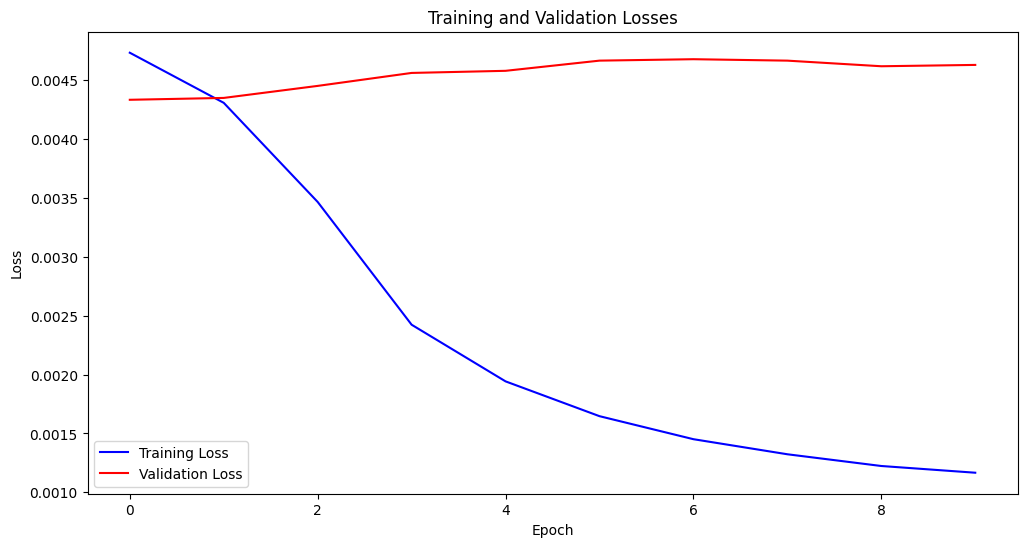

In [ ]:
train_epoch_losses, val_epoch_losses = train(model, nn.MSELoss(), 10, 0.001, train_dataloader, val_dataloader)

plot_train_results(train_epoch_losses, val_epoch_losses)

In [ ]:
def evaluate_model(model, dataloader, sigmoid_threshold):
  model.eval()

  predictions = []
  labels = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      sigmoid_outputs = torch.sigmoid(outputs)
      current_predictions = (sigmoid_outputs > sigmoid_threshold)

      predictions.extend(current_predictions.cpu().numpy())
      labels.extend((y_batch > 0.0).cpu().numpy()) # 0.0 rated texts are not jokes, positive rated texts are jokes.

  return predictions, labels


def find_best_sigmoid_threshold(model, val_dataloader):
  best_f1_score = 0.0
  best_sigmoid_threshold = 0.5

  sigmoid_thresholds = []
  precisions = []
  recalls = []
  f1_scores = []

  for sigmoid_threshold in np.arange(0.0, 1.0, 0.05):
    val_predictions, val_labels = evaluate_model(model, val_dataloader, sigmoid_threshold)

    precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary', zero_division=0)

    if f1_score > best_f1_score:
      best_f1_score = f1_score
      best_sigmoid_threshold = sigmoid_threshold

    sigmoid_thresholds.append(sigmoid_threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    print('Sigmoid Threshold:', sigmoid_threshold, 'Precision:', precision, 'Recall:', recall, 'F1 Score:', f1_score)

  plt.figure(figsize=(12, 6))
  plt.plot(sigmoid_thresholds, f1_scores, marker='o', linestyle='-', color='blue')
  plt.xlabel('Sigmoid Threshold')
  plt.ylabel('F1 Score')
  plt.title('F1 Score Evolution')
  plt.legend()
  plt.show()

  return best_sigmoid_threshold


def plot_best_sigmoid_threshold_results(predictions, labels):
  conf_matrix = confusion_matrix(labels, predictions)

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Joke', 'Joke'], yticklabels=['Not Joke', 'Joke'])

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  plt.show()

  if len(np.unique(labels)) == 2:
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
  else:
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)

  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1_score)

  return precision, recall, f1_score

Sigmoid Threshold: 0.0 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.05 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.1 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.15000000000000002 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.2 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.25 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.30000000000000004 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.35000000000000003 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.4 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.45 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid T

<ipython-input-20-a0fdc931dbec>:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


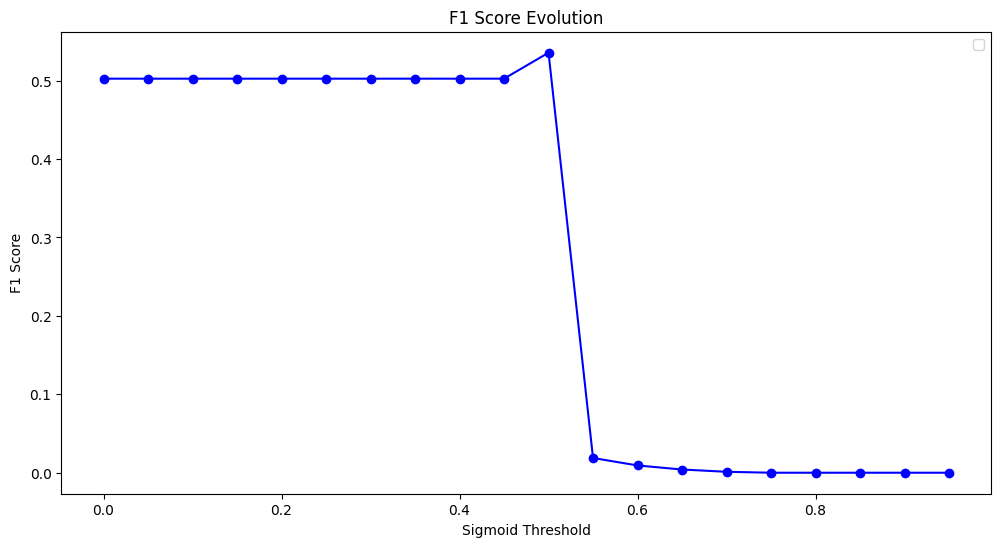

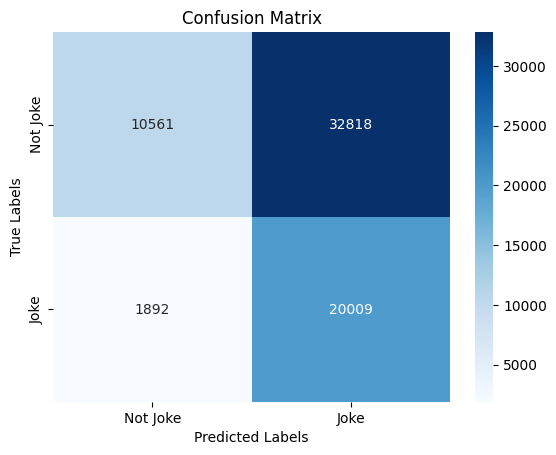

Precision: 0.37876464686618583
Recall: 0.9136112506278252
F1 Score: 0.5355154694358206


In [ ]:
best_sigmoid_threshold = find_best_sigmoid_threshold(model, val_dataloader)

val_predictions, val_labels = evaluate_model(model, val_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(val_predictions, val_labels)

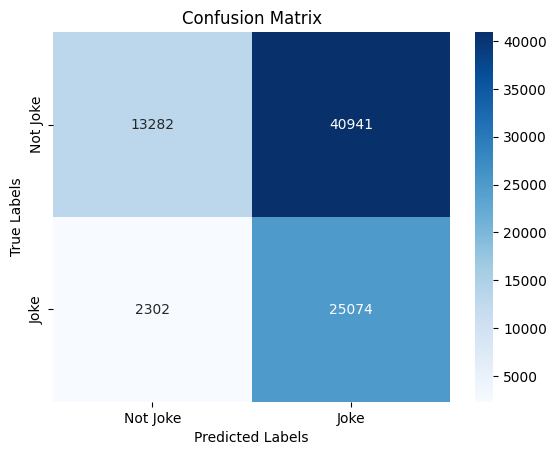

Precision: 0.3798227675528289
Recall: 0.9159117475160725
F1 Score: 0.536968230343395


In [ ]:
test_predictions, test_labels = evaluate_model(model, test_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(test_predictions, test_labels)